In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sn
import os
import critical_loads as cl
import imp
import matplotlib.pyplot as plt
import folium
import geopandas as gpd

In [2]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')
resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)
engine, conn = resa2_basic.connect_to_resa2()

# Exceedance of critical loads for water

This workbook develops a new methodology for the calculation of critical loads for water. For background information, see e-mail sent to Kari 18/10/2017 at 13.39 and reply received 18/10/2017 at 16.30.

## 1. Extract data from database

### 1.1. Deposition

Deposition data are contained in three tables: `RESA2.AIR_PARAMETER_DEFINITIONS`, `RESA2.DEP_SERIES_DEFINITIONS` and `RESA2.DEP_BLR_VALUES`. For S deposition, we use non-marine S (`S*`), which has parameter ID 4, and for N we must sum `N(oks)` and `N(red)`. We are interested in the following time periods: 1978-1982, 1992-1996, 1997-2001, 2002-2006, 2007-2011, which have series IDs [1, 2, 3, 4, 25] respectively.

**Note:** As with vegetation, we need to upload new data for 2012-2016 and then process this period as well.

All the calculations should be performed in meq/l/m2.

In [3]:
# Get dep data
sql = ("SELECT a.blr, b.name AS series, c.name AS par, a.value AS dep "
       "FROM resa2.dep_blr_values a, "
       "resa2.dep_series_definitions b, "
       "resa2.air_parameter_definitions c "
       "WHERE a.parameter_id IN (1, 2, 4) "
       "AND a.dep_series_id IN (1, 2, 3, 4, 25) "
       "AND a.parameter_id = c.parameter_id "
       "AND a.dep_series_id = b.dep_series_id")

dep_df = pd.read_sql(sql, engine)

# Tidy
dep_df['series'] = dep_df['series'].str[7:]
dep_df['par'] = dep_df['par'].str[:1]

# Group N(oks) and N(red)
dep_df = dep_df.groupby(['blr', 'series', 'par']).sum()

# Unstack
dep_df = dep_df.unstack('par')
dep_df.columns = dep_df.columns.get_level_values('par')

# Convert to meq/l
dep_df['N'] = dep_df['N'] / 14.
dep_df['S'] = dep_df['S']*2. / 32.06

# Unstack
dep_df = dep_df.unstack('series')

# Flatten col index
dep_df.columns = ['%s_%s' % (p, d) for p, d in zip(dep_df.columns.get_level_values('par'), 
                                                   dep_df.columns.get_level_values('series'))]

dep_df.head()

,N_1978-1982,N_1992-1996,N_1997-2001,N_2002-2006,N_2007-2011,S_1978-1982,S_1992-1996,S_1997-2001,S_2002-2006,S_2007-2011
blr,,,,,,,,,,
58006001,121.428571,126.512143,112.636429,NaN,97.391429,99.812851,71.092327,54.825951,NaN,34.838428
58006002,123.489286,89.075000,82.091429,85.187857,98.853571,102.973175,47.747973,37.151591,32.061759,33.953837
58006003,86.958571,83.657143,75.672857,82.670714,85.939286,73.114161,46.873362,35.324392,30.809732,27.877105
58006004,99.449286,93.594286,101.810714,93.010714,79.455714,83.024953,49.577667,46.839676,34.863381,25.993762
58006005,92.377143,93.052143,89.655000,74.112143,84.609286,77.626326,52.674984,41.373674,27.650031,29.220836


## 2. Get critical loads

Critical loads are currently calculated by some mysterious code in the database. Eventually it would be good to tidy this up, but as the values are "static" and time is limited this year, we have agreed to just read the data directly from the database and worry about this later. All the necessary quantities are in the view `RESA2.CLA`:

 * **CLAOAAVAROAA**. The critical load, adjusted for organic acids <br><br>
 * **ENO3FL**. The nitrate flux. Used only for the SSWC model. This is the quantity $N_{le}$ in equation VII.13 of [Max's PDF](http://www.rivm.nl/media/documenten/cce/manual/binnenop17Juni/Ch7-MapMan-2016-04-26_vf.pdf) (section VII.6.1) <br><br>
 * **CLMINN, CLMAXNOAA and CLMAXSOAA**. Parameters to define the critical load function. In Max's notation, these are $CLN_{min}$, $CLN_{max}$ and $CLS_{max}$, respectively (but adjusted for organic acids) - see section VII.4 of the [PDF](http://www.rivm.nl/media/documenten/cce/manual/binnenop17Juni/Ch7-MapMan-2016-04-26_vf.pdf). Note that a fourth parameter, $CLS_{min}$, is also required, but this is assumed to be zero for all BLR cells (see Kari's e-mail received 18/10/2017 at 16.30)

In [4]:
# Get dep data
sql = ("SELECT blr, claoaavaroaa, eno3fl, clminn, clmaxnoaa, clmaxsoaa "
       "FROM resa2.cla")

cl_df = pd.read_sql(sql, engine)

# Set index
cl_df.index = cl_df['blr']
del cl_df['blr']

# Add CLSmin as 0
cl_df['clmins'] = 0

cl_df.head()

,claoaavaroaa,eno3fl,clminn,clmaxnoaa,clmaxsoaa,clmins
blr,,,,,,
60506013,46.689055,20.499,3.204124,59.153507,47.083568,0
60508003,47.240467,8.988,3.204124,70.544508,48.610725,0
60509002,48.396218,0.029,14.635616,100.955383,51.368535,0
60511002,11.156834,0.080,7.077605,27.656760,11.903564,0
60511006,34.764804,1.081,42.316831,121.992502,38.498971,0


## 3. Calculate exceedances

### 3.1. Check data and join

In [5]:
# Check dfs are compatible
assert len(dep_df) == len(cl_df), 'Lengths of dataframes do not match.'
assert dep_df.index.is_unique, 'dep_df has duplicated BLR IDs.'
assert cl_df.index.is_unique, 'cl_df has duplicated BLR IDs.'

# Join
df = dep_df.join(cl_df, how='left')

# Fill NaN with 0
df.fillna(0, inplace=True)

df.head()

,N_1978-1982,N_1992-1996,N_1997-2001,N_2002-2006,N_2007-2011,S_1978-1982,S_1992-1996,S_1997-2001,S_2002-2006,S_2007-2011,claoaavaroaa,eno3fl,clminn,clmaxnoaa,clmaxsoaa,clmins
blr,,,,,,,,,,,,,,,,
58006001,121.428571,126.512143,112.636429,0.000000,97.391429,99.812851,71.092327,54.825951,0.000000,34.838428,28.533538,35.544,3.204124,40.514435,29.056767,0
58006002,123.489286,89.075000,82.091429,85.187857,98.853571,102.973175,47.747973,37.151591,32.061759,33.953837,32.029772,27.861,3.204124,43.473268,32.471152,0
58006003,86.958571,83.657143,75.672857,82.670714,85.939286,73.114161,46.873362,35.324392,30.809732,27.877105,20.888186,25.137,3.204124,29.564269,21.184960,0
58006004,99.449286,93.594286,101.810714,93.010714,79.455714,83.024953,49.577667,46.839676,34.863381,25.993762,18.914393,36.846,25.972633,49.911208,19.189395,0
58006005,92.377143,93.052143,89.655000,74.112143,84.609286,77.626326,52.674984,41.373674,27.650031,29.220836,20.463044,47.587,3.204124,30.057701,20.846989,0


### 3.2. SSWC model

For SSWC, exceedances are calculated as:

$$Sdep + ENO3FL – CLAOAAVAROAA$$

In [6]:
# Define time periods
periods = ['1978-1982', '1992-1996', '1997-2001', '2002-2006', '2007-2011']

# Copy df
sswc_df = df.copy()

# Loop over periods
for per in periods:
    sswc_df['sswc_ex_%s' % per] = (sswc_df['S_%s' % per] + 
                                   sswc_df['eno3fl'] - 
                                   sswc_df['claoaavaroaa'])

# Get cols of interest
cols = ['sswc_ex_%s' % per for per in periods]
sswc_df = sswc_df[cols]

# Set values below 0 to 0
sswc_df[sswc_df<0] = 0

# Write to output
out_path = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water\sswc_exceedance.csv')
sswc_df.to_csv(out_path)

sswc_df.head()

,sswc_ex_1978-1982,sswc_ex_1992-1996,sswc_ex_1997-2001,sswc_ex_2002-2006,sswc_ex_2007-2011
blr,,,,,
58006001,106.823313,78.102789,61.836413,7.010462,41.848890
58006002,98.804403,43.579201,32.982819,27.892987,29.785065
58006003,77.362975,51.122176,39.573206,35.058546,32.125919
58006004,100.956560,67.509274,64.771282,52.794988,43.925369
58006005,104.750281,79.798940,68.497630,54.773987,56.344792


### 3.3. FAB model

For FAB, exceedances should be calculated using the method described in section VII.4 of [Max's PDF](http://www.rivm.nl/media/documenten/cce/manual/binnenop17Juni/Ch7-MapMan-2016-04-26_vf.pdf). I have already refactored Max's code to Python [here](http://nbviewer.jupyter.org/github/JamesSample/critical_loads/blob/master/notebooks/icpmap_exceed.ipynb?flush_cache=true). 

Additionally, it's perhaps worth plotting the critical loads function for each BLR cell, as this creates potential for some interesting visualisations.

In [7]:
# Define time periods
periods = ['1978-1982', '1992-1996', '1997-2001', '2002-2006', '2007-2011']

# Plot folder
png_fold = r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water\CLF_PNGs'

# Copy df
fab_df = df.copy()

# Loop over periods
for per in periods:
    print 'Processing %s...' % per
    
    # Containers for data
    fab_ex_n = []
    fab_ex_s = []
    fab_ex_reg = []
    
    # Loop over rows
    for idx, row in df.iterrows():
        # Calc exceedance
        ex_n, ex_s, reg_id = cl.exceed_ns_icpm(row['clminn'], row['clmaxnoaa'],
                                               row['clmins'], row['clmaxsoaa'],
                                               row['N_%s' % per], row['S_%s' % per])
        
        # Add to result
        fab_ex_n.append(ex_n)
        fab_ex_s.append(ex_s)
        fab_ex_reg.append(reg_id)
        
        # Plot
#        out_png = os.path.join(png_fold, 'blr_%s_%s.png' % (idx, per))
#        cl.plot_critical_loads_func(row['clminn'], row['clmaxnoaa'],
#                                    row['clmins'], row['clmaxsoaa'],
#                                    [row['N_%s' % per],], [row['S_%s' % per]],
#                                    title='%s (%s)' % (idx, per), save_png=True, 
#                                    png_path=out_png)
#        plt.close()
        
    # Add to df
    fab_df['fab_ex_n_%s' % per] = fab_ex_n
    fab_df['fab_ex_s_%s' % per] = fab_ex_s
    fab_df['fab_ex_reg_%s' % per] = fab_ex_reg
    
    # Calc total ex = ex_n + ex_s
    fab_df['fab_ex_%s' % per] = fab_df['fab_ex_n_%s' % per] + fab_df['fab_ex_s_%s' % per]

# Get cols of interest
cols = [i for i in fab_df.columns if i[:3]=='fab']
fab_df = fab_df[cols]

# Set values below 0 to 0
fab_df[fab_df<0] = 0

# Write to output
out_path = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water\fab_exceedance.csv')
fab_df.to_csv(out_path)

print 'Finished.'

fab_df.head()

Processing 1978-1982...
Processing 1992-1996...
Processing 1997-2001...
Processing 2002-2006...
Processing 2007-2011...
Finished.


,fab_ex_n_1978-1982,fab_ex_s_1978-1982,fab_ex_reg_1978-1982,fab_ex_1978-1982,fab_ex_n_1992-1996,fab_ex_s_1992-1996,fab_ex_reg_1992-1996,fab_ex_1992-1996,fab_ex_n_1997-2001,fab_ex_s_1997-2001,fab_ex_reg_1997-2001,fab_ex_1997-2001,fab_ex_n_2002-2006,fab_ex_s_2002-2006,fab_ex_reg_2002-2006,fab_ex_2002-2006,fab_ex_n_2007-2011,fab_ex_s_2007-2011,fab_ex_reg_2007-2011,fab_ex_2007-2011
blr,,,,,,,,,,,,,,,,,,,,
58006001,80.914136,99.812851,2,180.726987,85.997708,71.092327,2,157.090034,72.121993,54.825951,2,126.947945,0.000000,0.000000,0,0.000000,56.876993,34.838428,2,91.715421
58006002,81.844111,101.499086,3,183.343197,45.601732,47.747973,2,93.349704,38.618160,37.151591,2,75.769751,41.714589,32.061759,2,73.776348,55.380303,33.953837,2,89.334140
58006003,58.224030,72.447331,3,130.671361,54.092874,46.873362,2,100.966237,46.108588,35.324392,2,81.432980,53.106446,30.809732,2,83.916177,56.375017,27.877105,2,84.252122
58006004,59.897117,74.721047,3,134.618163,43.683077,49.577667,2,93.260744,51.899506,46.839676,2,98.739181,43.099506,34.863381,2,77.962887,29.544506,25.993762,2,55.538268
58006005,62.319442,77.626326,2,139.945768,62.994442,52.674984,2,115.669427,59.597299,41.373674,2,100.970974,44.054442,27.650031,2,71.704474,54.551585,29.220836,2,83.772421


### 3.4. Area exceeded

For each model, we need the total area exceeded in each time period.

First read the BLR shapefile, which includes cell areas.

In [8]:
# Read BLR grid
in_shp = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS'
          r'\Shapefiles\blrgrid_uten_grums.shp')
blr_df = gpd.read_file(in_shp)

# Convert to 'normal' df
del blr_df['geometry']
blr_df = pd.DataFrame(blr_df)

# Get total area of Norway by summing cells
nor_area = blr_df['area_m2'].sum()/1E6

blr_df.head()

,BLR,area_m2
0,58005004,5.410322e+07
1,58006001,1.939285e+08
2,58006002,2.044114e+08
3,58006003,2.043394e+08
4,58006004,2.042695e+08


#### 3.4.1. SSWC

In [9]:
# Container for output
data_dict = {'period':[],
             'area_exceeded_km2':[],
             'area_total_km2':[]}

# Caclulate area exceeded
for col in sswc_df.columns:
    per = col[-9:]
    
    # Get BLRs exceeded
    ex_blr = sswc_df[sswc_df[col]>0].index
    
    # Get area exceeded
    area_ex = blr_df['area_m2'][blr_df['BLR'].isin(ex_blr)].sum()/1E6
    
    # Add to output
    data_dict['period'].append(per)
    data_dict['area_exceeded_km2'].append(area_ex)
    data_dict['area_total_km2'].append(nor_area)
    
# Build df
sswc_areas = pd.DataFrame(data_dict)
sswc_areas.index = sswc_areas['period']
del sswc_areas['period']

# Pct exceed
sswc_areas['pct_exceed'] = 100*sswc_areas['area_exceeded_km2']/nor_area

# Tidy
sswc_areas = sswc_areas.round(0).astype(int)

# Write output
out_csv = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water'
           r'\sswc_area_exceeded.csv')
sswc_areas.to_csv(out_csv)

sswc_areas

,area_exceeded_km2,area_total_km2,pct_exceed
period,,,
1978-1982,100964,322183,31
1992-1996,55695,322183,17
1997-2001,42949,322183,13
2002-2006,35351,322183,11
2007-2011,26773,322183,8


#### 3.4.2. FAB

In [10]:
# Get cols for overall exceedance
periods = ['1978-1982', '1992-1996', '1997-2001', '2002-2006', '2007-2011']
cols = ['fab_ex_%s' % i for i in periods]
fab = fab_df[cols]

# Container for output
data_dict = {'period':[],
             'area_exceeded_km2':[],
             'area_total_km2':[]}

# Caclulate area exceeded
for col in fab.columns:
    per = col[-9:]
    
    # Get BLRs exceeded
    ex_blr = fab[fab[col]>0].index
    
    # Get area exceeded
    area_ex = blr_df['area_m2'][blr_df['BLR'].isin(ex_blr)].sum()/1E6
    
    # Add to output
    data_dict['period'].append(per)
    data_dict['area_exceeded_km2'].append(area_ex)
    data_dict['area_total_km2'].append(nor_area)
    
# Build df
fab_areas = pd.DataFrame(data_dict)
fab_areas.index = fab_areas['period']
del fab_areas['period']

# Pct exceed
fab_areas['pct_exceed'] = 100*fab_areas['area_exceeded_km2']/nor_area

# Tidy
fab_areas = fab_areas.round(0).astype(int)

# Write output
out_csv = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water'
           r'\fab_area_exceeded.csv')
fab_areas.to_csv(out_csv)

fab_areas

,area_exceeded_km2,area_total_km2,pct_exceed
period,,,
1978-1982,135904,322183,42
1992-1996,94119,322183,29
1997-2001,79389,322183,25
2002-2006,75100,322183,23
2007-2011,65009,322183,20


### 3.5. Visualisation

There are some interesting visualisation possibilities here. First of all, read the BLR shapefile (in WGS84 geographic co-ordinates) and convert it to GeoJSON (as this is easier to display in a browser). 

In [11]:
## Read BLR grid
#in_shp = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS'
#          r'\Shapefiles\blrgrid_uten_grums.shp')
#
#blr_df = gpd.read_file(in_shp)
#
## Convert to geojson
#out_path = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS'
#            r'\Shapefiles\blrgrid_wgs84.json')
#blr_df.to_file(out_path, driver="GeoJSON")

Secondly, convert the GeoJSON to TopoJSON. TopoJSON is a topologically correct extension to GeoJSON, and for polygones with lots of common boundaries, it is much more effiicent and gives huge reductions in file size. This is important, as the raw GeoJSON file is ~4 MB, which is too large for Folium (the map just doesn't display), but the TopoJSON version is only about 1 MB, which is OK. [This website](https://mygeodata.cloud/converter/geojson-to-topojson) makes it easy to convert GeoJSON to TopoJSON (the free version only allows limited usage, but this is OK for now). The converted TopoJSON file is here:

C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS\Shapefiles\blrgrid_wgs84.topojson

We can now try a choropleth map.

In [12]:
# Column of interest
data_col = 'fab_ex_1978-1982'

# Path to topojson
topo_path = r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS\Shapefiles\blrgrid_wgs84.topojson'

# Get data
df = fab_df.copy()
df.index.name = 'BLR'
df.reset_index(inplace=True)

# Map
m = folium.Map(location=[65, 10], zoom_start=4)

m.choropleth(geo_path=topo_path,
             data=df,
             columns= ['BLR', data_col],
             key_on='feature.properties.BLR',
             fill_color='YlOrRd',
             fill_opacity=0.7,
             line_opacity=0.2,
             legend_name='Exceedance (meq/l)',
             topojson='objects.test')

m

More sophisticated visualisation is possible using Fusion Tables. The code below just shows one time period, but a version where peiods can be selected would be fairly simple too. For the demo, I've copied all the CLF PNGs from 2007 to 2011 to a new folder here:

C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water\CLF_PNGs_2007-2011

And then uploaded them to a location online.

The code below gets just the FAB data for this time period, joins it to the BLR shapefile and writes a new shapefile that can be used as the basis for the fusion map.

In [13]:
# Read exceedance data
in_csv = r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water\fab_exceedance.csv'
df = pd.read_csv(in_csv)

# Read BLR grid
in_shp = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS'
          r'\Shapefiles\blrgrid_uten_grums.shp')
blr_df = gpd.read_file(in_shp)

# Get cols of interest
df = df[['blr', 'fab_ex_2007-2011', 'fab_ex_reg_2007-2011']]

# Shorten names
df.columns = ['BLR', 'exceed', 'ex_reg']

# Add col with PNG url
base_url = 'http://77.104.141.195/~icpwater/wp-content/icpmap_exceed_plots/'
df['url'] = base_url + 'blr_' + df['BLR'].map(str) + '_2007-2011.png'

# Join shape to data
gdf = blr_df.merge(df, on='BLR')
del gdf['area_m2']

# Write to shapefile
out_shp = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\GIS\Shapefiles'
           r'\fab_exceed_2007-2011.shp')
gdf.to_file(out_shp)

This shapefile can be converted to KML using:

    ogr2ogr -f KML fab_exceed_2007-2011.kml fab_exceed_2007-2011.shp
    
and this can be uploaded to Fusion Tables and further customised for visualisation.

A first attempt is [here](https://fusiontables.google.com/embedviz?q=select+col6+from+1FJbAbZ-fB6UcDGABLkv5TKHljKmGTHGRLEukTI9R&viz=MAP&h=false&lat=61.63863460204371&lng=9.56805419921875&t=1&z=6&l=col6&y=2&tmplt=2&hml=KML), which includes CLF pop-ups so I can check the results are consistent.

## 4. Checking

The calculations above should produce the same output as previously reported for the SSWC model, and exceedances should at least be comparable for FAB (although the method has substantially changed). The code below performs some basic checking.

### 4.1. SSWC

**Note:** The values in the "old" Excel file appear to use `CLAOAA` for the critical loads, and not `CLAOAAVAROAA`, as I have used above. I this `CLAOAAVAROAA` is correct for this year, but this explains the minor differences on the plots below.

In [14]:
# Read new results
in_csv = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water'
          r'\sswc_exceedance.csv')
sswc_new = pd.read_csv(in_csv, index_col=0)

# Tidy headings
sswc_new.columns = [i[-9:] for i in sswc_new.columns]
sswc_new.reset_index(inplace=True)

# Read old results
in_xlsx = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water'
          r'\Old_Results\arealer - SSWCoaa.xlsx')
sswc_old = pd.read_excel(in_xlsx, sheetname='Sheet1')
sswc_old[sswc_old<0] = 0

# Join
sswc_df = pd.merge(sswc_new, sswc_old, how='left', on='blr',
                   suffixes=('_new', '_old'))

sswc_df.head()

,blr,1978-1982_new,1992-1996_new,1997-2001_new,2002-2006_new,2007-2011_new,1978-1982_old,1992-1996_old,1997-2001_old,2002-2006_old,2007-2011_old
0,58006001,106.823313,78.102789,61.836413,7.010462,41.848890,104.482451,75.765510,59.501163,NaN,39.516133
1,58006002,98.804403,43.579201,32.982819,27.892987,29.785065,97.254711,42.036398,31.441338,26.352141,28.243983
2,58006003,77.362975,51.122176,39.573206,35.058546,32.125919,76.405322,50.167797,38.620267,34.106171,31.173910
3,58006004,100.956560,67.509274,64.771282,52.794988,43.925369,100.831955,67.388841,64.651192,52.676391,43.807878
4,58006005,104.750281,79.798940,68.497630,54.773987,56.344792,102.990600,78.042371,66.742471,53.020540,54.591149


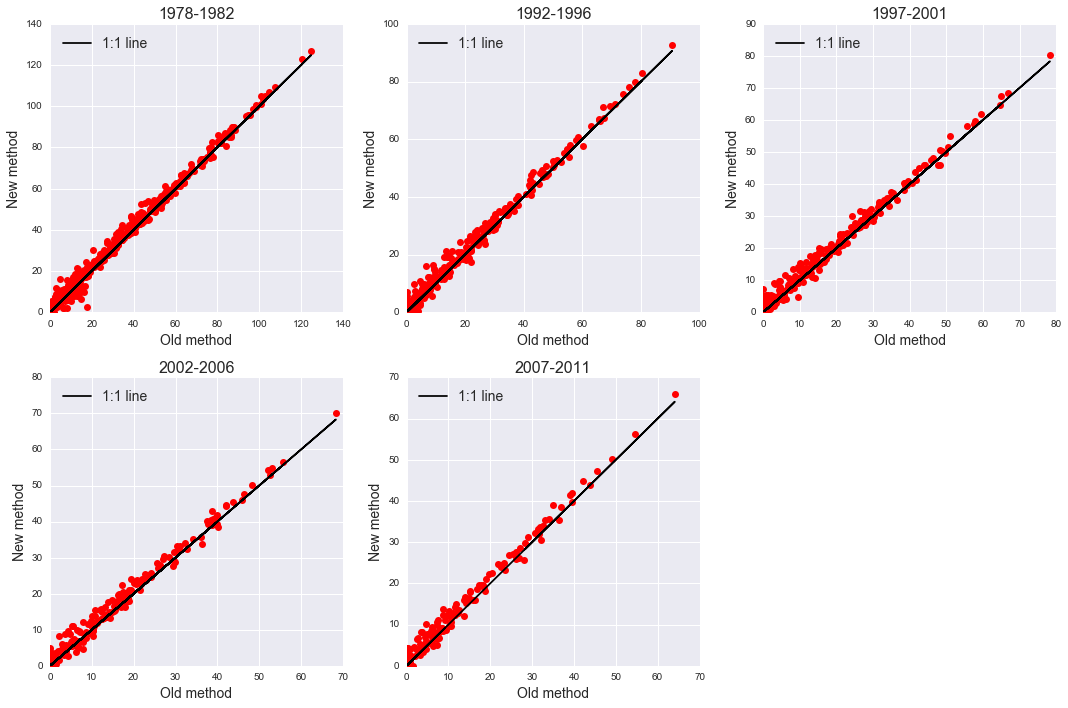

In [15]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axes = axes.flatten()
plt.delaxes(axes[-1])

# Loop over data
periods = ['1978-1982', '1992-1996', '1997-2001', '2002-2006', '2007-2011']
for idx, per in enumerate(periods):
    axes[idx].plot(sswc_df[per+'_old'], sswc_df[per+'_new'], 'ro',
                   label='')
    axes[idx].plot(sswc_df[per+'_old'], sswc_df[per+'_old'], 'k-', 
                   label='1:1 line')
    axes[idx].set_title(per, fontsize=16)
    axes[idx].set_xlabel('Old method', fontsize=14)
    axes[idx].set_ylabel('New method', fontsize=14)    
    axes[idx].legend(loc='upper left', fontsize=14)

plt.tight_layout()

### 4.2. FAB

In [16]:
# Read new results
in_csv = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water'
          r'\fab_exceedance.csv')
fab_new = pd.read_csv(in_csv, index_col=0)

# Get cols
cols = ['fab_ex_%s' % i for i in periods]
fab_new = fab_new[cols]

# Tidy headings
fab_new.columns = [i[-9:] for i in fab_new.columns]
fab_new.reset_index(inplace=True)

# Read old results
in_xlsx = (r'C:\Data\James_Work\Staff\Kari_A\Critical_Loads\water'
          r'\Old_Results\arealer -FAB.xlsx')
fab_old = pd.read_excel(in_xlsx, sheetname='Sheet1')
fab_old[fab_old<0] = 0

# Join
fab_df = pd.merge(fab_new, fab_old, how='left', on='blr',
                  suffixes=('_new', '_old'))

fab_df.head()

,blr,1978-1982_new,1992-1996_new,1997-2001_new,2002-2006_new,2007-2011_new,1978-1982_old,1992-1996_old,1997-2001_old,2002-2006_old,2007-2011_old
0,58006001,180.726987,157.090034,126.947945,0.000000,91.715421,158.592350,133.737717,106.931119,NaN,75.363506
1,58006002,183.343197,93.349704,75.769751,73.776348,89.334140,164.297553,81.878449,65.763627,63.121824,75.814942
2,58006003,130.671361,100.966237,81.432980,83.916177,84.252122,117.049231,88.212110,70.377630,71.373754,71.015217
3,58006004,134.618163,93.260744,98.739181,77.962887,55.538268,120.307104,82.267102,85.980350,67.096477,47.585636
4,58006005,139.945768,115.669427,100.970974,71.704474,83.772421,122.740993,98.303755,84.432139,58.943907,68.461095


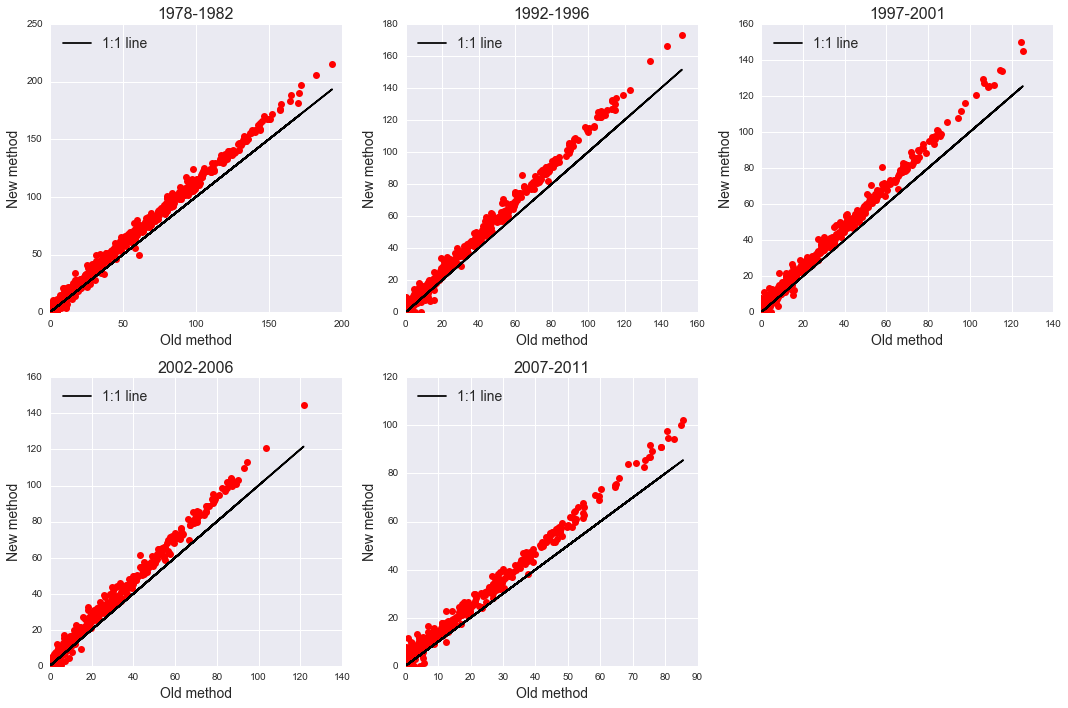

In [17]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axes = axes.flatten()
plt.delaxes(axes[-1])

# Loop over data
periods = ['1978-1982', '1992-1996', '1997-2001', '2002-2006', '2007-2011']
for idx, per in enumerate(periods):
    axes[idx].plot(fab_df[per+'_old'], fab_df[per+'_new'], 'ro',
                   label='')
    axes[idx].plot(fab_df[per+'_old'], fab_df[per+'_old'], 'k-', 
                   label='1:1 line')
    axes[idx].set_title(per, fontsize=16)
    axes[idx].set_xlabel('Old method', fontsize=14)
    axes[idx].set_ylabel('New method', fontsize=14)    
    axes[idx].legend(loc='upper left', fontsize=14)

plt.tight_layout()